## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/cardio/cardio_maccs_train.csv")
df_test = pd.read_csv("../../data/train/cardio/cardio_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/cardio/cardio_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'pIC50']
y_train = df_train_all['pIC50']

X_test = df_test.loc[:, df_test.columns != 'pIC50']
y_test = df_test['pIC50']

In [5]:
X_train.shape, y_train.shape

((8505, 166), (8505,))

In [6]:
X_test.shape, y_test.shape

((2127, 166), (2127,))

## 3. Metrics 📏

In [7]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [8]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 1, 'solver': 'cholesky', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 0.6115355478489
MSE: 0.6829493863508082
RMSE: 0.8264075183290676
R2 Square 0.23751814588812126 

Base model:
MAE: 0.6119482742273566
MSE: 0.694853015905307
RMSE: 0.833578440163436
R2 Square 0.22422828617849833 

Train set:
Tuned model:
MAE: 0.5977644228257839
MSE: 0.6600472797083693
RMSE: 0.8124329385914688
R2 Square 0.2730580916096469 

Base model:
MAE: 0.6013851569245258
MSE: 0.6751120328593859
RMSE: 0.821652014455868
R2 Square 0.2564665522734524 



In [9]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518


## 4.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [13]:
# default: 'n_estimators': 100, 'max_depth': None

params = {
    'max_depth': [5, 10, 12, 13],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 0.43026173464346595
MSE: 0.36725315895173444
RMSE: 0.6060141573855634
R2 Square 0.589978591148299 

Base model:
MAE: 0.4334586856607892
MSE: 0.3739862496254276
RMSE: 0.6115441518201508
R2 Square 0.582461402373575 

Train set:
Tuned model:
MAE: 0.30748398322951254
MSE: 0.1824987991454442
RMSE: 0.42719878176961623
R2 Square 0.7990052691553351 

Base model:
MAE: 0.3102881647578776
MSE: 0.18624018766769712
RMSE: 0.4315555441280961
R2 Square 0.7948846974993198 



In [10]:
params = {'max_depth': 13, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 0.43026173464346595
MSE: 0.36725315895173444
RMSE: 0.6060141573855634
R2 Square 0.589978591148299 

Train set:
MAE: 0.30748398322951254
MSE: 0.1824987991454442
RMSE: 0.42719878176961623
R2 Square 0.7990052691553351 



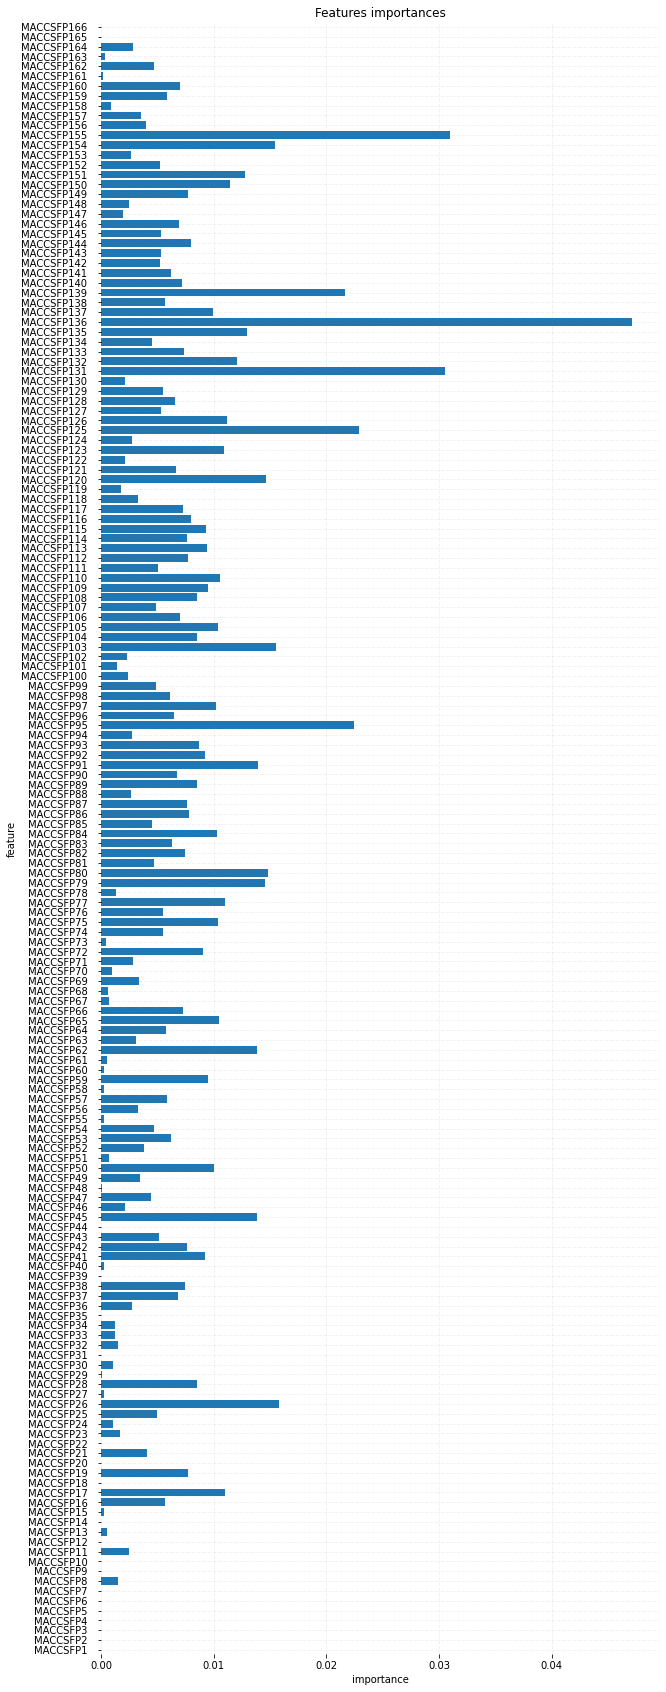

In [11]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [11]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [71]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [4, 8, 10, 15],
    'n_estimators': [500, 1000, 2000, 3000, 4000],
    'min_child_weight': [155, 185, 225],
    'colsample_bytree': [0.3],
    'subsample': [0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 'min_child_weight': 155, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 0.44028675789075533
MSE: 0.3822356753727693
RMSE: 0.6182521131162992
R2 Square 0.5732512946190299 

Base model:
MAE: 0.45521936619538306
MSE: 0.3932633415908227
RMSE: 0.6271071213045046
R2 Square 0.5609394080392692 

Train set:
Tuned model:
MAE: 0.3505214977733569
MSE: 0.2424777150006896
RMSE: 0.49242026258135396
R2 Square 0.7329475958712925 

Base model:
MAE: 0.3552807231479518
MSE: 0.245729066713452
RMSE: 0.4957106683474262
R2 Square 0.7293667253918807 



In [12]:
params = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 155, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 0.44028675789075533
MSE: 0.3822356753727693
RMSE: 0.6182521131162992
R2 Square 0.5732512946190299 

Train set:
MAE: 0.3505214977733569
MSE: 0.2424777150006896
RMSE: 0.49242026258135396
R2 Square 0.7329475958712925 



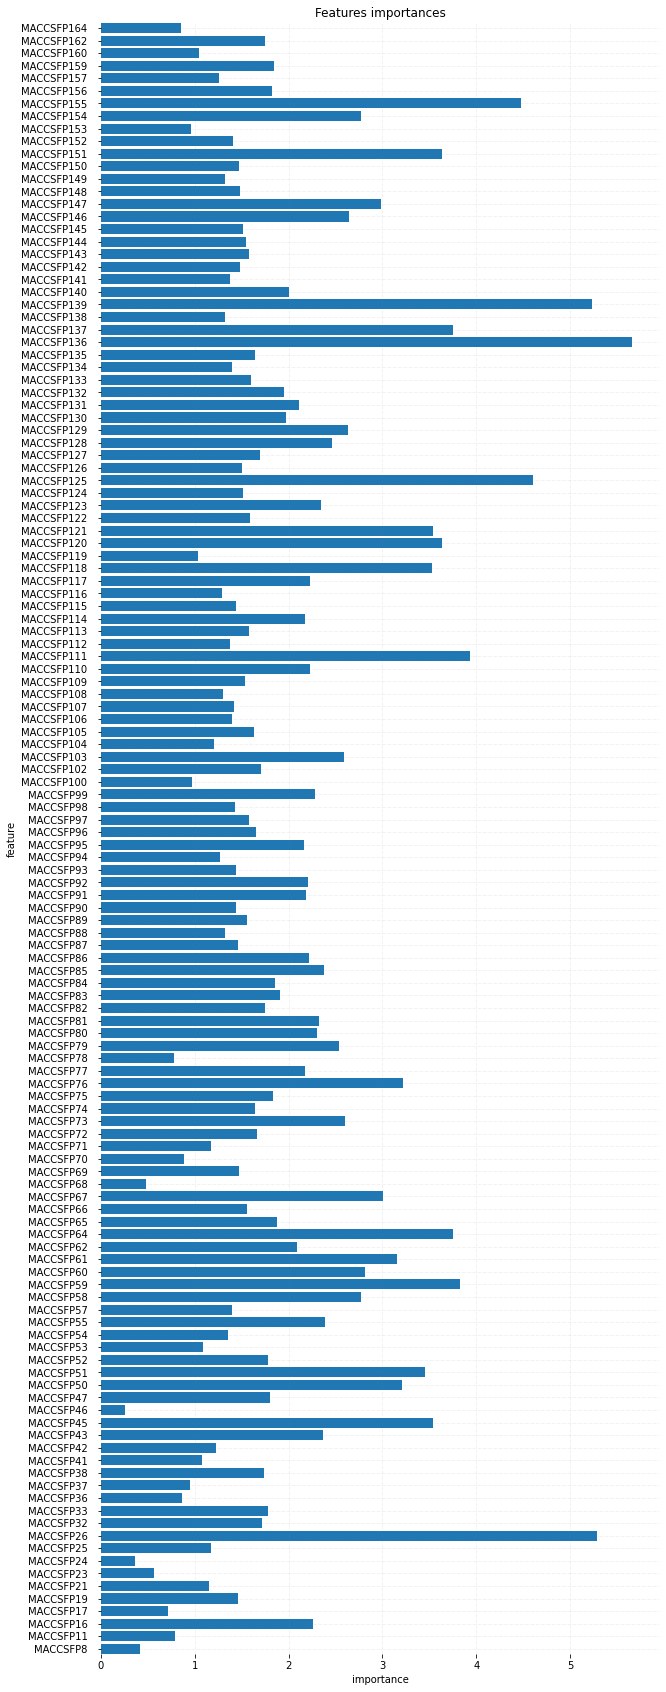

In [15]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [13]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251


## 4.4. LightGBM

Better results - third model.

In [85]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000, 4000, 5000],
    'min_child_samples': [40, 50],
    'reg_alpha': [2.7, 2.9, 3.2],
    'reg_lambda': [0.04, 0.06],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 50, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 0.45168903592607
MSE: 0.3995207588738132
RMSE: 0.6320765451065348
R2 Square 0.5539532869192547 

Base model:
MAE: 0.4655844068768942
MSE: 0.4118987546056884
RMSE: 0.6417933893440227
R2 Square 0.5401338189990051 

Train set:
Tuned model:
MAE: 0.3849240763010588
MSE: 0.28847149358814084
RMSE: 0.537095423168119
R2 Square 0.6822924288729257 

Base model:
MAE: 0.4011800862385373
MSE: 0.3044451972546039
RMSE: 0.5517655274250141
R2 Square 0.6646998184882709 



In [14]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 0.45379306185375645
MSE: 0.40250139714975847
RMSE: 0.6344299781297842
R2 Square 0.5506255401718374 

Train set:
MAE: 0.3884280952185133
MSE: 0.2932483153076068
RMSE: 0.5415240671545511
R2 Square 0.6770314846897707 



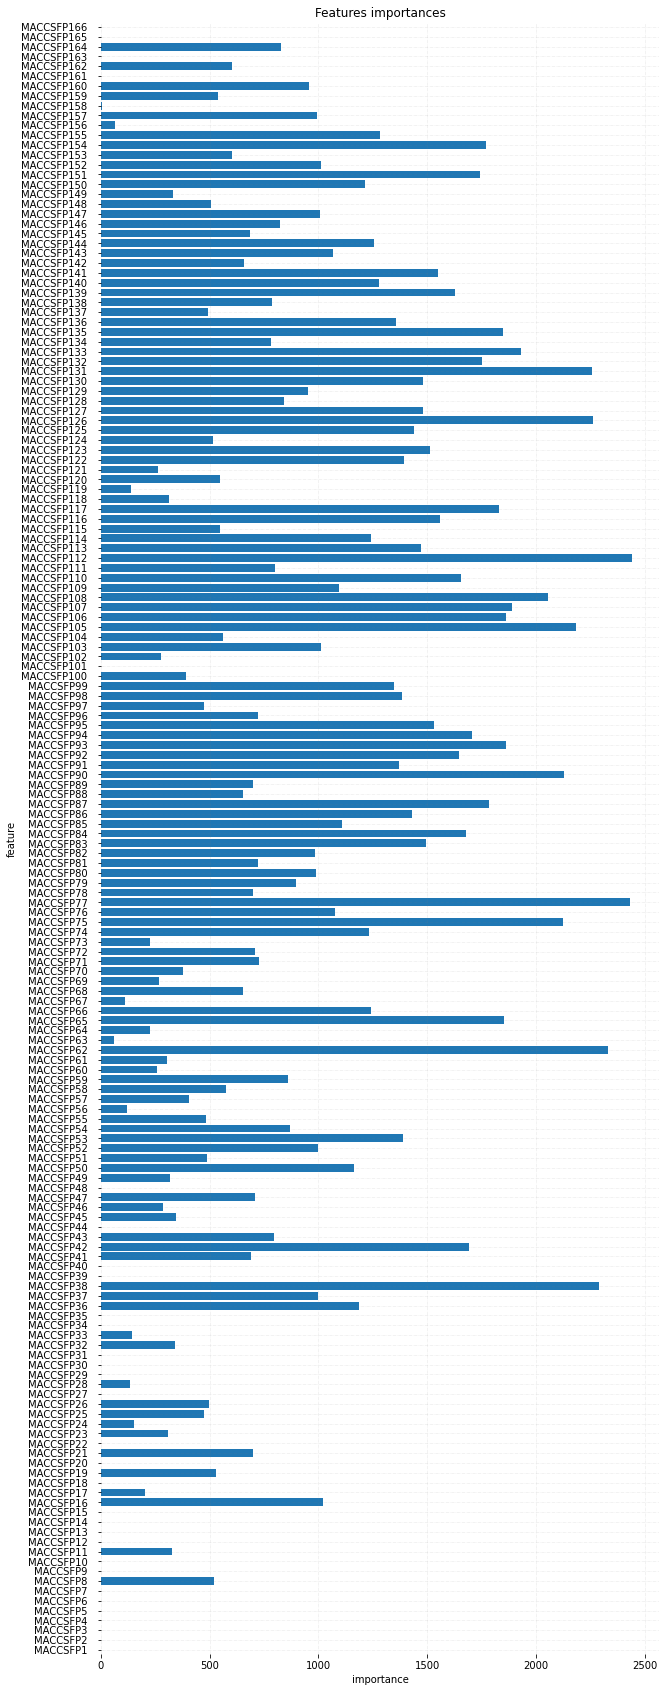

In [20]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [27]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0

params = {
    'learning_rate': [0.001, 0.005, 0.1],
    'max_depth': [5, 10, 15, 20],
    'l2_regularization': [0, 0.1, 0.2],
    'min_samples_leaf':[8, 10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 0.46498150680233385
MSE: 0.40864732509009716
RMSE: 0.6392552894502299
R2 Square 0.5437638918200804 

Base model:
MAE: 0.46558440778878324
MSE: 0.4118987548166049
RMSE: 0.6417933895083409
R2 Square 0.5401338187635265 

Train set:
Tuned model:
MAE: 0.3955661292732532
MSE: 0.29298007952796107
RMSE: 0.5412763430337234
R2 Square 0.677326905693006 

Base model:
MAE: 0.4011800868074402
MSE: 0.30444519756113136
RMSE: 0.5517655277027836
R2 Square 0.6646998181506774 



In [16]:
params = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 0.46498150680233385
MSE: 0.40864732509009716
RMSE: 0.6392552894502299
R2 Square 0.5437638918200804 

Train set:
MAE: 0.3955661292732532
MSE: 0.29298007952796107
RMSE: 0.5412763430337234
R2 Square 0.677326905693006 



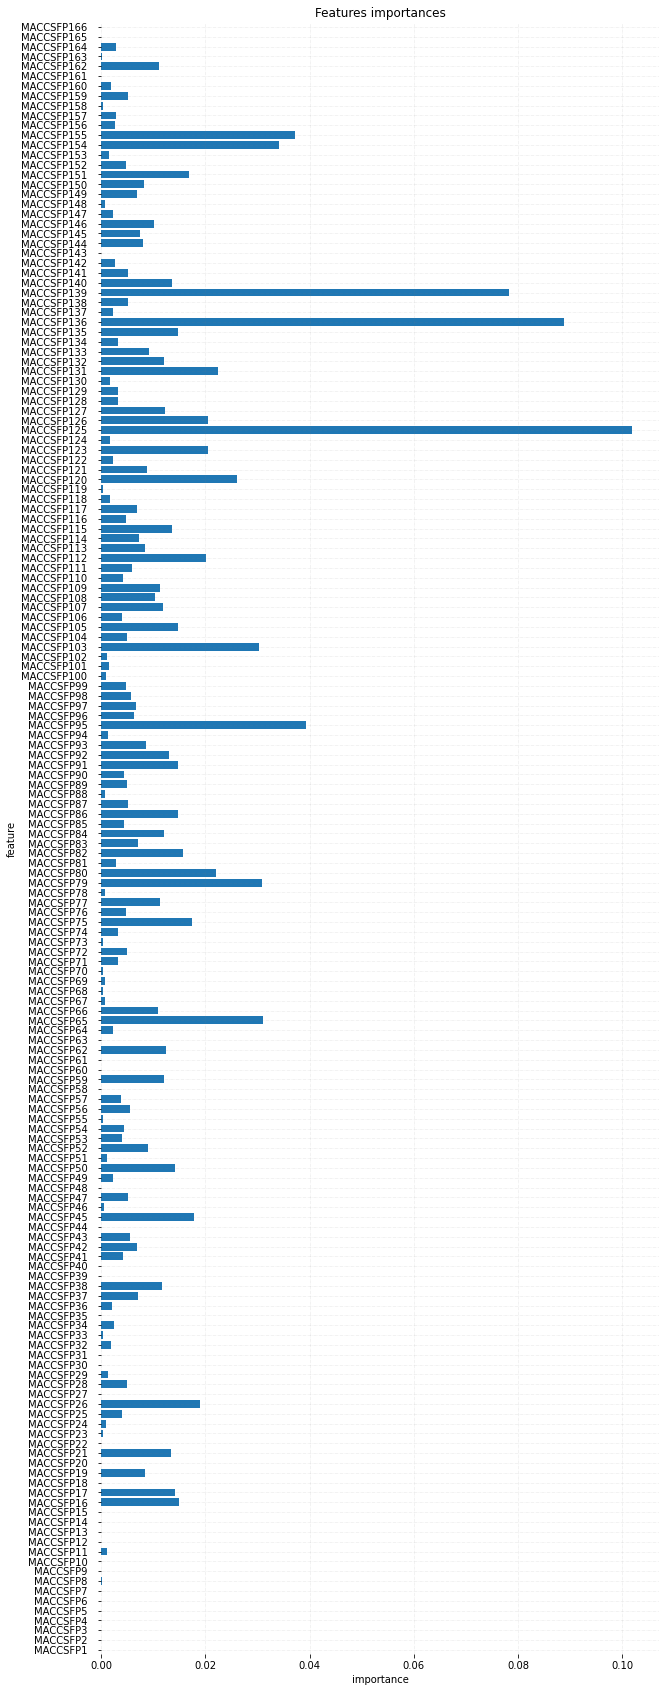

In [40]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [17]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626
4,HistGradient Boosting Regressor,0.464982,0.408647,0.639255,0.543764


## 4.6. Support Vector Regression

Better results - fifth model.

In [26]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0],
    'epsilon': [0.1, 0.001, 0.0001],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 3.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 0.425477374263533
MSE: 0.3887616048374761
RMSE: 0.6235075018293493
R2 Square 0.5659653918896335 

Base model:
MAE: 0.45771425640822616
MSE: 0.4633830727671194
RMSE: 0.6807224638331831
R2 Square 0.48265392494833637 

Train set:
Tuned model:
MAE: 0.29682886498825867
MSE: 0.24335978584990098
RMSE: 0.49331509793427264
R2 Square 0.7319761286958737 

Base model:
MAE: 0.3793564384022883
MSE: 0.3645100521503306
RMSE: 0.6037466787903107
R2 Square 0.5985474963934336 



In [18]:
params = {'C': 3.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 0.425477374263533
MSE: 0.3887616048374761
RMSE: 0.6235075018293493
R2 Square 0.5659653918896335 

Train set:
MAE: 0.29682886498825867
MSE: 0.24335978584990098
RMSE: 0.49331509793427264
R2 Square 0.7319761286958737 



In [ ]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [19]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626
4,HistGradient Boosting Regressor,0.464982,0.408647,0.639255,0.543764
5,Support Vector Regression,0.425477,0.388762,0.623508,0.565965


### Save models

In [46]:
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))

## 4.7. Stacking models

### Averaging base models

In [20]:
def average_predictions(X):
    return ((0.3 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.15 * lgbm_best.predict(X)) + \
            (0.15 * hist_best.predict(X)) + \
            (0.15 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 0.42871950717182833
MSE: 0.3661982690829111
RMSE: 0.6051431806464574
R2 Square 0.5911563275942779 

Train set:
MAE: 0.3319495347753324
MSE: 0.2217159481829879
RMSE: 0.4708672298886257
R2 Square 0.7558135311701759 



In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626
4,HistGradient Boosting Regressor,0.464982,0.408647,0.639255,0.543764
5,Support Vector Regression,0.425477,0.388762,0.623508,0.565965
6,Averaging base models,0.428720,0.366198,0.605143,0.591156


### Averaging base models with Meta-model

In [22]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [23]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.536776,4.633209,4.584589,4.595498,4.472118
1,4.522560,4.476968,4.534438,4.531878,4.481762
2,5.255155,5.220557,5.224104,5.205389,5.271607
3,5.251754,5.364027,5.370488,5.349447,5.171749
4,4.391725,4.331680,4.473012,4.615991,4.142987
...,...,...,...,...,...
8500,5.022357,4.965065,4.982212,5.031345,4.982574
8501,4.357374,4.310599,4.452771,4.582910,4.200002
8502,5.432284,5.668784,5.792262,5.503637,5.581595
8503,4.747982,5.125917,4.979393,4.947920,4.757202


In [24]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 0.4194921486019894
MSE: 0.36395930672709836
RMSE: 0.603290399995805
R2 Square 0.5936560269899662 

Train set:
MAE: 0.2508678267044555
MSE: 0.1333656309347398
RMSE: 0.3651925943043476
R2 Square 0.8531179973831291 



In [25]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626
4,HistGradient Boosting Regressor,0.464982,0.408647,0.639255,0.543764
5,Support Vector Regression,0.425477,0.388762,0.623508,0.565965
6,Averaging base models,0.428720,0.366198,0.605143,0.591156
7,Base models + Meta-model,0.419492,0.363959,0.603290,0.593656


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [26]:
params_rf = {'max_depth': 13, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.6, 'max_depth': 15, 
          'min_child_weight': 155, 'n_estimators': 4000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 50, 'n_estimators': 5000, 'num_leaves': 60, 'reg_alpha': 2.7, 'reg_lambda': 0.04, 
          'subsample': 0.8}

params_hist = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_samples_leaf': 10} 

params_svr = {'C': 3.0, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} 

In [27]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
    
        
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 0.40951938266203575
Model1 R2: 0.53704336518686
Model2 MSE: 0.3930138955863381
Model2 R2: 0.5557026157035149
Model3 MSE: 0.41313331361289274
Model3 R2: 0.5329578606117651
Model4 MSE: 0.4240947163664964
Model4 R2: 0.5205661293617017
Model5 MSE: 0.39563254374355245
Model5 R2: 0.5527422661084773
Average MSE = 0.40707877039426305
Average R2 = 0.5398024473944638
-------------- fold 2 --------------
Model1 MSE: 0.39224774023861647
Model1 R2: 0.5937531731317698
Model2 MSE: 0.39579338533236014
Model2 R2: 0.5900809860908501
Model3 MSE: 0.42158237706020807
Model3 R2: 0.5633716007131397
Model4 MSE: 0.408693604298808
Model4 R2: 0.5767203660453739
Model5 MSE: 0.41715788919364316
Model5 R2: 0.5679539958984263
Average MSE = 0.40709499922472714
Average R2 = 0.5783760243759121
-------------- fold 3 --------------
Model1 MSE: 0.38298460480524993
Model1 R2: 0.5446091828660766
Model2 MSE: 0.39292300285708787
Model2 R2: 0.532791853519039
Model3 MSE: 0.417491

In [28]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [29]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [30]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.565891,4.721757,4.682211,4.769711,4.497236
1,4.565056,4.436015,4.482491,4.536186,4.481627
2,5.015518,5.199195,5.173862,4.961750,5.057909
3,5.366305,5.419013,5.351678,5.434595,5.251501
4,4.458038,4.423059,4.557781,4.552135,4.260542
...,...,...,...,...,...
8500,4.971285,4.830356,4.845230,4.923889,4.937124
8501,4.397270,4.398889,4.466794,4.539913,4.259046
8502,5.466917,5.792490,5.951499,5.547861,5.581300
8503,4.718400,5.077339,4.989357,4.860691,4.644528


In [31]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,4.523151,3.900594,3.881707,4.137091,3.960993
1,4.679182,4.708101,4.787435,4.869472,4.477848
2,4.711639,4.646130,4.612341,4.666858,4.478979
3,4.883928,4.827970,4.896827,4.851108,4.847551
4,5.420980,5.293620,5.376264,5.465123,5.304389
...,...,...,...,...,...
2122,4.850102,5.013459,4.997690,5.181720,4.919855
2123,5.662517,5.868940,5.832285,5.512957,5.895853
2124,4.993517,4.842488,4.854456,5.025973,4.750154
2125,6.001013,6.296697,6.242978,6.046583,6.193216


In [32]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 0.4152852557717902
MSE: 0.35291682408135056
RMSE: 0.5940680298428376
R2 Square 0.6059844554357648 

Train set:
MAE: 0.42057726652551736
MSE: 0.36687191816056747
RMSE: 0.6056995279514155
R2 Square 0.595946259425072 



In [33]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,0.611536,0.682949,0.826408,0.237518
1,Random Forest Regressor,0.430262,0.367253,0.606014,0.589979
2,XGBoost,0.440287,0.382236,0.618252,0.573251
3,LightGBM,0.453793,0.402501,0.634430,0.550626
4,HistGradient Boosting Regressor,0.464982,0.408647,0.639255,0.543764
5,Support Vector Regression,0.425477,0.388762,0.623508,0.565965
6,Averaging base models,0.428720,0.366198,0.605143,0.591156
7,Base models + Meta-model,0.419492,0.363959,0.603290,0.593656
8,Base models + Meta-model + cv,0.415285,0.352917,0.594068,0.605984
